In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('ticks')
from scipy import stats
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
kc = pd.read_csv('kc_norm.csv')
data_norm = pd.read_csv('data_norm.csv')

kc = kc.drop(columns = 'Unnamed: 0')
data_norm = data_norm.drop(columns = 'Unnamed: 0')


## Model 1

In [3]:
kcnew = pd.concat([  kc.waterfront, kc.grade,kc.view, data_norm],axis = 1)

X = kcnew
y = kc.price

# Add a constant
#X_int = sm.add_constant(X)
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          3.335e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        17:38:13   Log-Likelihood:                     -1.6409e+05
No. Observations:               12615   AIC:                                  3.282e+05
Df Residuals:                   12607   BIC:                                  3.283e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
waterfront             2.264e+05   2.78e+04      8.139      0.000    1.72e+05    2.81e+05
grade                  6.175e+04    132.297    466.789      0.000    6.15e+04     6.2e+04
view                   3.328e+04   1780.637     18.689      0.000    2.98e+04    3.68e+04
sqft_living            9.265e+04   1085.288     85.365      0.000    9.05e+04    9.48e+04
sqft_lot               -674.9984   1083.619     -0.623      0.533   -2799.057    1449.060
age                    2.593e+04   1180.012     21.976      0.000    2.36e+04    2.82e+04
distance_from_city    -8.648e+04   1157.930    -74.682      0.000   -8.87e+04   -8.42e+04
distance_from_airport  5.194e+04    971.941     53.440      0.000       5e+04    5.38e+04
==============================================================================
Omnibus:                     1044.277   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2128.277
Skew:                           0.553   Prob(JB):                         0.00
Kurtosis:                       4.681   Cond. No.                         218.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

8 7
['waterfront', 'grade', 'view', 'sqft_living', 'age']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
waterfront,2.264e+05,2.78e+04,8.139,0.000,1.72e+05,2.81e+05
grade,6.175e+04,132.297,466.789,0.000,6.15e+04,6.2e+04
view,3.328e+04,1780.637,18.689,0.000,2.98e+04,3.68e+04
sqft_living,9.265e+04,1085.288,85.365,0.000,9.05e+04,9.48e+04
sqft_lot,-674.9984,1083.619,-0.623,0.533,-2799.057,1449.060


In [5]:
# Your code here - Code a way to identify multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = kcnew
vif = [variance_inflation_factor((X.astype(float)).values,i) for i in range(X.shape[1])]
list(zip(x_cols,vif))

[('waterfront', 1.063055701522352),
 ('grade', 1.0764952986808374),
 ('view', 1.1826573576180668),
 ('sqft_living', 1.2757366413827294),
 ('age', 1.2718165043854475),
 ('distance_from_city', 1.5081488456002823),
 ('distance_from_airport', 1.4522300740175884)]

In [6]:
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

7 7


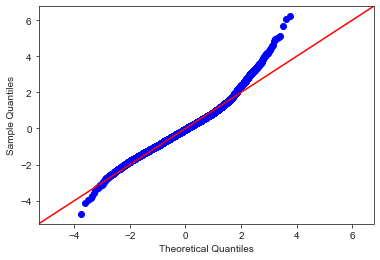

In [7]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

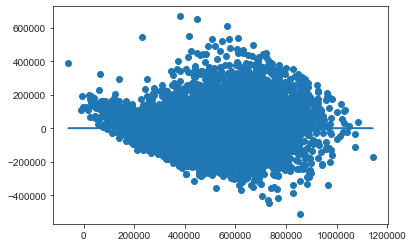

In [8]:
plt.scatter(model.predict(kcnew), model.resid)
plt.plot(model.predict(kcnew), [0 for i in range(len(kc))])

In [9]:
def plot_residuals(resids):
    plt.hist(resids)
    plt.title("Residuals")
    plt.show()
    
    xspace = np.linspace(0, 1, len(resids))
    plt.scatter(xspace, resids)
    plt.title("resids")
    plt.hlines(0, xmin=0, xmax=1)
    plt.show()

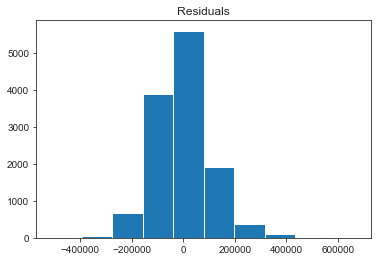

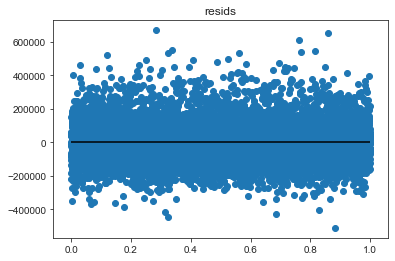

In [10]:
residuals = model.resid
plot_residuals(residuals)

In [11]:
ols = LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)
cv5_scores = np.mean(cross_val_score(ols, X, y, scoring='r2', cv=5, n_jobs=-1) )
cv10_scores = np.mean(cross_val_score(ols, X, y, scoring='r2', cv=10, n_jobs=-1) )
cv20_scores = np.mean(cross_val_score(ols, X, y, scoring='r2', cv=20, n_jobs=-1) )

# cv breaks your data into that many equal pieces 
cv5_scores,cv10_scores,cv20_scores

(0.7151026275040537, 0.7139523435975692, 0.7139920875403383)

In [12]:
cv5mae_scores = np.mean(cross_val_score(ols, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1) )
cv10mae_scores = np.mean(cross_val_score(ols, X, y, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1) )
cv20mae_scores = np.mean(cross_val_score(ols, X, y, scoring='neg_mean_absolute_error', cv=20, n_jobs=-1) )

# cv breaks your data into that many equal pieces 
cv5mae_scores,cv10mae_scores,cv20mae_scores

(-82276.9050003571, -82275.47121399106, -82207.0119043672)

In [13]:
X_shuff, y_shuff = shuffle(X, y)
cv_scores = cross_val_score(ols, X_shuff, y_shuff, scoring='r2', cv=5, n_jobs=-1) 
cv_scores.mean()

0.7164463850047207

train R2 score = 0.7146617183096
test R2 score = 0.726153370293099
cv5 R2 score = 0.7151026275040537
cv10 R2 score = 0.7139523435975692
cv5 MSE score = -11680076998.979948
cv10  MSE score = -11684423340.033224


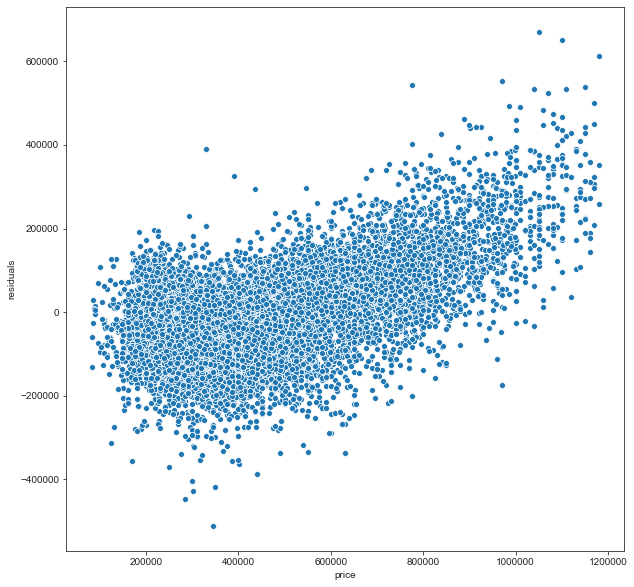

In [14]:
def make_ols_sklearn(X, y, test_size=0.20, fit_intercept=False, standardize=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    if standardize:
        ss = StandardScaler()
        ss.model(X_train)
        X_train = ss.transform(X_train)
        X_test = ss.transform(X_test)
    ols = LinearRegression(fit_intercept=fit_intercept, normalize=False)
    ols.fit(X_train, y_train)
    train_score = ols.score(X_train, y_train)
    test_score = ols.score(X_test, y_test)
    cv5_scores = np.mean(cross_val_score(ols, X, y, scoring='r2', cv=5, n_jobs=-1) )
    cv10_scores = np.mean(cross_val_score(ols, X, y, scoring='r2', cv=10, n_jobs=-1) )
    cvmse_5 = np.mean(cross_val_score(ols,X , y, cv=5, scoring='neg_mean_squared_error'))
    cvmse_10 = np.mean(cross_val_score(ols,X, y, cv=10, scoring='neg_mean_squared_error'))
    print(f"train R2 score = {train_score}")
    print(f"test R2 score = {test_score}")
    print(f"cv5 R2 score = {cv5_scores}")
    print(f"cv10 R2 score = {cv10_scores}")
    print(f"cv5 MSE score = {cvmse_5}")
    print(f"cv10  MSE score = {cvmse_10}")

    return ols


make_ols_sklearn(X, y)


residuals = model.resid
resid = pd.DataFrame(kc['price'])
resid['residuals']  = residuals

plt.figure(figsize= (10,10))

sns.scatterplot(y='residuals',x='price',data=resid)


In [19]:
from sklearn.model_selection import cross_validate

x=kcnew
y=kc.price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [20]:
clf = LinearRegression()
clf.fit(x_train,y_train)
accuracy = clf.score(x_test, y_test)

In [21]:
print(accuracy)

0.7179414821639623


In [ ]:
#precting = clf.predict()